In [ ]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import os

# Configuração do Jira
JIRA_URL = os.getenv('JIRA_URL', "https://bancomaster.atlassian.net")  
JIRA_EMAIL = os.getenv('JIRA_EMAIL', 'rjunior.nava@bancomaster.com.br')  
JIRA_TOKEN = os.getenv('JIRA_API_TOKEN', '')  # AJUSTE AQUI

def descobrir_campo_responsavel():
    """
    Descobre o campo customizado correto para responsável usando um item conhecido
    """
    # Usar o item SMD-2180 como referência que sabemos ter "Neilanny Amorim Fernandes"
    url = f"{JIRA_URL}/rest/api/3/issue/SMD-2180"
    
    try:
        response = requests.get(
            url,
            auth=HTTPBasicAuth(JIRA_EMAIL, JIRA_TOKEN),
            headers={'Accept': 'application/json'}
        )
        
        if response.status_code == 200:
            issue_data = response.json()
            fields = issue_data['fields']
            
            # Procurar "Neilanny Amorim Fernandes" em todos os campos customizados
            for field_key, field_value in fields.items():
                if field_key.startswith('customfield_') and field_value is not None:
                    nome_encontrado = None
                    
                    if isinstance(field_value, dict) and 'displayName' in field_value:
                        nome_encontrado = field_value.get('displayName', '')
                    elif isinstance(field_value, str):
                        nome_encontrado = field_value
                    
                    if nome_encontrado and 'Neilanny Amorim Fernandes' in nome_encontrado:
                        print(f"✅ Campo responsável descoberto: {field_key}")
                        return field_key
        
        print("❌ Campo responsável não encontrado no item de referência")
        return None
        
    except Exception as e:
        print(f"❌ Erro ao descobrir campo responsável: {str(e)}")
        return None

def buscar_sprint_jira(projeto, sprint_id, todos_tipos=True):
    """
    Busca dados de uma sprint específica no Jira via API
    
    Args:
        projeto: Nome do projeto no Jira
        sprint_id: ID da sprint
        todos_tipos: Se True, busca todos os tipos de issue
    
    Returns:
        dict: Dados da sprint em formato JSON
    """
    # Descobrir o campo responsável correto
    campo_responsavel = descobrir_campo_responsavel()
    if not campo_responsavel:
        campo_responsavel = 'assignee'  # fallback
    
    # Query JQL com projeto configurável
    jql = f'project = "{projeto}" AND Sprint = {sprint_id}'
    
    if not todos_tipos:
        jql += " AND issuetype in (Story, Bug, Task)"
    
    # Ordenar por Story Points (customfield_10031)
    jql += " ORDER BY cf[10031] ASC"
    
    print(f"🔍 Executando JQL: {jql}")
    
    # URL da API do Jira
    url = f"{JIRA_URL}/rest/api/3/search"
    
    # Parâmetros da requisição - incluir apenas o campo responsável descoberto
    fields_busca = f'key,summary,issuetype,status,assignee,priority,created,resolutiondate,customfield_10031'
    if campo_responsavel != 'assignee':
        fields_busca += f',{campo_responsavel}'
    
    params = {
        'jql': jql,
        'maxResults': 100,
        'fields': fields_busca
    }
    
    try:
        # Fazer requisição à API
        response = requests.get(
            url,
            params=params,
            auth=HTTPBasicAuth(JIRA_EMAIL, JIRA_TOKEN),
            headers={'Accept': 'application/json'}
        )
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ Erro ao buscar sprint {sprint_id}: Status {response.status_code}")
            print(f"   Resposta: {response.text}")
            return None
            
    except Exception as e:
        print(f"❌ Erro ao conectar com Jira: {str(e)}")
        return None

def processar_dados_sprint(data):
    """
    Processa dados da sprint
    """
    if not data or 'issues' not in data:
        return pd.DataFrame()
        
    dados = []
    campo_responsavel_cache = None
    
    for i, issue in enumerate(data['issues']):
        fields = issue['fields']
        
        # Calcular lead time
        lead_time = None
        if fields.get('created') and fields.get('resolutiondate'):
            try:
                created = pd.to_datetime(fields['created'])
                resolved = pd.to_datetime(fields['resolutiondate'])
                lead_time = (resolved - created).days
            except:
                pass
        
        # Buscar responsável no campo descoberto ou usar assignee como fallback
        responsavel = "Não atribuído"
        
        # Descobrir campo apenas na primeira iteração
        if i == 0:
            campo_responsavel_cache = descobrir_campo_responsavel()
        
        if campo_responsavel_cache and campo_responsavel_cache != 'assignee' and fields.get(campo_responsavel_cache):
            valor_campo = fields[campo_responsavel_cache]
            
            if isinstance(valor_campo, dict) and 'displayName' in valor_campo:
                responsavel = valor_campo.get('displayName', 'Não identificado')
            elif isinstance(valor_campo, str) and len(valor_campo) < 100:
                responsavel = valor_campo
        
        # Fallback para assignee se não encontrou responsável
        if responsavel == "Não atribuído" and fields.get('assignee'):
            responsavel = fields['assignee'].get('displayName', 'Não identificado')
        
        # Story Points apenas para tipos ágeis
        tipo_item = fields['issuetype']['name']
        if tipo_item in ['História', 'Debito Tecnico', 'Spike']:
            story_points = fields.get('customfield_10031', 0) or 0
        else:
            story_points = 0
            
        dados.append({
            'Chave': issue['key'],
            'Tipo de Item': tipo_item,
            'Status': fields['status']['name'],
            'Resumo': fields.get('summary', '')[:60] + '...' if len(fields.get('summary', '')) > 60 else fields.get('summary', ''),
            'Responsável': responsavel,
            'Prioridade': fields.get('priority', {}).get('name', 'N/A') if fields.get('priority') else 'N/A',
            'Criado': fields.get('created', '')[:10],
            'Resolvido': fields.get('resolutiondate', '')[:10] if fields.get('resolutiondate') else '',
            'Lead Time (dias)': lead_time,
            'Story Points': story_points
        })
    return pd.DataFrame(dados)

# Funções para métricas ágeis
def mostrar_distribuicao_por_tipo(df):
    """Mostra distribuição por tipo de item focando nos tipos ágeis"""
    print("\\n📊 DISTRIBUIÇÃO POR TIPO DE ITEM:")
    
    # Filtrar apenas tipos ágeis de interesse
    tipos_ageis = ['Debito Tecnico', 'História', 'Spike']
    df_filtrado = df[df['Tipo de Item'].isin(tipos_ageis)]
    
    if len(df_filtrado) == 0:
        print("   Nenhum item dos tipos ágeis (Débito Técnico, História, Spike) encontrado")
        return
    
    tipo_counts = df_filtrado['Tipo de Item'].value_counts()
    for tipo, count in tipo_counts.items():
        print(f"   {tipo}: {count}")
    
    # Gráfico com quantidade nas barras
    plt.figure(figsize=(8,5))
    bars = tipo_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('Distribuição por Tipo de Item (Framework Ágil)', fontsize=14)
    plt.ylabel('Quantidade de Itens')
    plt.xlabel('Tipo de Item')
    plt.xticks(rotation=45)
    
    # Adicionar quantidade nas barras
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def mostrar_items_concluidos_ageis(df):
    """Mostra apenas itens ágeis concluídos"""
    tipos_ageis = ['História', 'Debito Tecnico', 'Spike']
    status_concluidos = ['Concluído', 'Done', 'Fechado', 'Finalizado', 'Resolvido']
    
    df_ageis = df[df['Tipo de Item'].isin(tipos_ageis)]
    df_concluidos = df_ageis[df_ageis['Status'].isin(status_concluidos)]
    
    print(f"\\n✅ ITENS ÁGEIS CONCLUÍDOS NA SPRINT: {len(df_concluidos)}")
    
    if len(df_concluidos) > 0:
        print("\\nItens concluídos (História, Débito Técnico, Spike):")
        colunas_exibir = ['Chave', 'Tipo de Item', 'Status', 'Resumo', 'Responsável']
        print(df_concluidos[colunas_exibir].to_string(index=False, justify='left'))
    
    return df_concluidos

def mostrar_story_points_ageis(df, df_concluidos):
    """Mostra Story Points apenas para tipos ágeis"""
    tipos_ageis = ['História', 'Debito Tecnico', 'Spike']
    
    # Filtrar apenas tipos ágeis
    df_ageis = df[df['Tipo de Item'].isin(tipos_ageis)]
    df_concluidos_ageis = df_concluidos[df_concluidos['Tipo de Item'].isin(tipos_ageis)]
    
    total_sp = df_ageis['Story Points'].sum()
    sp_concluidos = df_concluidos_ageis['Story Points'].sum()
    
    print(f"\\n🎯 STORY POINTS (APENAS ITENS ÁGEIS):")
    print(f"   Total planejado: {total_sp}")
    print(f"   Total concluído: {sp_concluidos}")
    print(f"   % Concluído: {(sp_concluidos/total_sp*100):.1f}%" if total_sp > 0 else "   N/A")
    
    # Mostrar detalhamento apenas de itens com Story Points
    df_com_sp = df_ageis[df_ageis['Story Points'] > 0]
    if len(df_com_sp) > 0:
        print(f"\\n📊 DETALHAMENTO DOS STORY POINTS:")
        print(df_com_sp[['Chave', 'Tipo de Item', 'Status', 'Story Points']].to_string(index=False))
        
        # Story Points por tipo
        print(f"\\n📈 STORY POINTS POR TIPO:")
        sp_por_tipo = df_com_sp.groupby('Tipo de Item')['Story Points'].sum().sort_values(ascending=False)
        for tipo, sp in sp_por_tipo.items():
            print(f"   {tipo}: {sp} pontos")
    else:
        print("\\n⚠️  Nenhum Story Point encontrado nos itens ágeis!")
        print("   Verifique se o campo customfield_10031 está correto para sua instância do Jira")
    
    # Gráfico de Story Points
    plt.figure(figsize=(10, 5))
    
    # Subplot 1: Planejado vs Concluído
    plt.subplot(1, 2, 1)
    plt.bar(['Planejado', 'Concluído'], [total_sp, sp_concluidos], 
            color=['#74B9FF', '#00B894'])
    plt.title('Story Points: Planejado vs Concluído')
    plt.ylabel('Story Points')
    
    # Adicionar valores nas barras
    for i, v in enumerate([total_sp, sp_concluidos]):
        plt.text(i, v + max(total_sp, sp_concluidos) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')
    
    # Subplot 2: Por tipo (se houver dados)
    if len(df_com_sp) > 0:
        plt.subplot(1, 2, 2)
        sp_por_tipo = df_com_sp.groupby('Tipo de Item')['Story Points'].sum()
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        bars = plt.bar(sp_por_tipo.index, sp_por_tipo.values, color=colors[:len(sp_por_tipo)])
        plt.title('Story Points por Tipo de Item')
        plt.ylabel('Story Points')
        plt.xticks(rotation=45)
        
        # Adicionar valores nas barras
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height * 0.01,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def mostrar_distribuicao_responsaveis(df):
    """Mostra distribuição de itens por responsável"""
    tipos_ageis = ['História', 'Debito Tecnico', 'Spike']
    df_ageis = df[df['Tipo de Item'].isin(tipos_ageis)]
    
    print(f"\\n👥 DISTRIBUIÇÃO DE ITENS POR RESPONSÁVEL (ITENS ÁGEIS):")
    responsavel_counts = df_ageis['Responsável'].value_counts()
    for responsavel, count in responsavel_counts.items():
        print(f"   {responsavel}: {count} itens")

def listar_issue_types(df):
    """Lista todos os tipos de issue da Sprint atual"""
    print(f"\\n📋 TODOS OS TIPOS DE ISSUE DA SPRINT:")
    issue_types = df['Tipo de Item'].value_counts()
    total_issues = len(df)
    
    for issue_type, count in issue_types.items():
        percentage = (count / total_issues * 100)
        print(f"   {issue_type}: {count} itens ({percentage:.1f}%)")
    
    print(f"\\n   Total de itens na sprint: {total_issues}")

def salvar_dados(df, projeto, sprint_id):
    filename = f"{projeto.replace(' ', '_').replace('[', '').replace(']', '')}_{sprint_id}_analysis.csv"
    print(f"\\n💾 Para salvar os dados:")
    print(f"df_sprint.to_csv('{filename}', index=False)")

def analisar_sprint(projeto, sprint_id):
    print(f"🚀 ANÁLISE DA SPRINT {sprint_id} - PROJETO {projeto}")
    print("="*70)
    
    data_sprint = buscar_sprint_jira(projeto, sprint_id, todos_tipos=True)
    if data_sprint:
        total_issues = data_sprint['total']
        print(f"✅ Total de issues na sprint: {total_issues}")
        if total_issues > 0:
            df_sprint = processar_dados_sprint(data_sprint)
            pd.set_option('display.colheader_justify', 'left')
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', 50)
            
            # Análises focadas em framework ágil
            listar_issue_types(df_sprint)
            mostrar_distribuicao_por_tipo(df_sprint)
            df_concluidos = mostrar_items_concluidos_ageis(df_sprint)
            mostrar_story_points_ageis(df_sprint, df_concluidos)
            mostrar_distribuicao_responsaveis(df_sprint)
            salvar_dados(df_sprint, projeto, sprint_id)
        else:
            print("❌ Nenhum issue encontrado na sprint")
    else:
        print("❌ Erro ao buscar dados da sprint")
    print(f"\\n🏁 Análise da sprint concluída!")
    print("="*70)

# Entrada dinâmica para análise de sprint
print("🔧 CONFIGURAÇÃO DA ANÁLISE")
print("="*40)

try:
    projeto_input = input('Digite o nome do projeto (ex: [DIGITAL] CredCesta CORE): ').strip()
    if not projeto_input:
        projeto_input = "[DIGITAL] CredCesta CORE"  # Valor padrão
        print(f"Usando projeto padrão: {projeto_input}")
except Exception:
    projeto_input = "[DIGITAL] CredCesta CORE"

try:
    sprint_id_input = int(input('Digite o número da Sprint para análise: '))
except Exception:
    sprint_id_input = 2614  # Valor padrão caso não seja informado corretamente
    print(f"Usando sprint padrão: {sprint_id_input}")

analisar_sprint(projeto_input, sprint_id_input)

print(f"\\n🔧 PARA ANALISAR OUTRAS SPRINTS:")
print("="*50)
print("Execute novamente a célula e digite o projeto e sprint desejados.")


🔧 CONFIGURAÇÃO DA ANÁLISE
🚀 ANÁLISE DA SPRINT 4450 - PROJETO smd
🔍 Executando JQL: project = "smd" AND Sprint = 4450 ORDER BY cf[10031] ASC
✅ Total de issues na sprint: 27

📋 TODOS OS TIPOS DE ISSUE DA SPRINT:
   Task-DevSecOps: 8 itens (29.6%)
   Subtarefa: 7 itens (25.9%)
   Task-QA: 4 itens (14.8%)
   História: 3 itens (11.1%)
   Debito Tecnico: 2 itens (7.4%)
   Bug-Task: 1 itens (3.7%)
   Impedimento: 1 itens (3.7%)
   Task-Arquitetura: 1 itens (3.7%)

   Total de itens na sprint: 27

📊 DISTRIBUIÇÃO POR TIPO DE ITEM:
   História: 3
   Debito Tecnico: 2


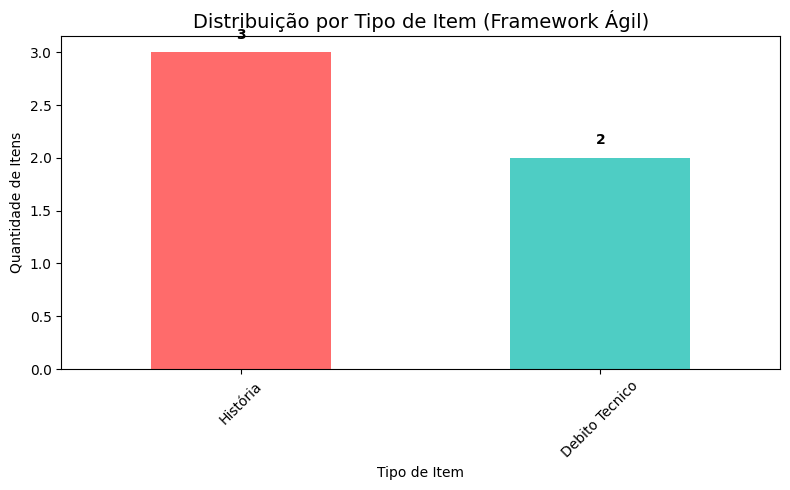


✅ ITENS ÁGEIS CONCLUÍDOS NA SPRINT: 1

Itens concluídos (História, Débito Técnico, Spike):
Chave    Tipo de Item Status    Resumo                                             Responsável
SMD-2085 História     Concluído [CMS] [Blog] - Status de Agendado para publicações Igor Prado 

🎯 STORY POINTS (APENAS ITENS ÁGEIS):
   Total planejado: 22.0
   Total concluído: 3.0
   % Concluído: 13.6%

📊 DETALHAMENTO DOS STORY POINTS:
Chave    Tipo de Item   Status                       Story Points
SMD-2158 Debito Tecnico Pronto para desenvolvimento 3.0          
SMD-2086       História                       Em QA 3.0          
SMD-2085       História                   Concluído 3.0          
SMD-1924       História                       Em QA 5.0          
SMD-2152 Debito Tecnico                Em andamento 8.0          

📈 STORY POINTS POR TIPO:
   Debito Tecnico: 11.0 pontos
   História: 11.0 pontos


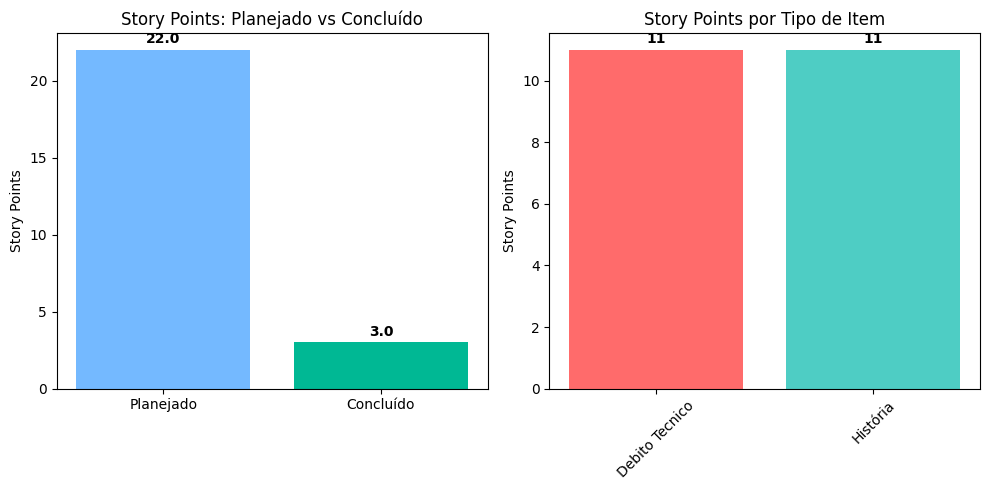


👥 DISTRIBUIÇÃO DE ITENS POR RESPONSÁVEL (ITENS ÁGEIS):
   Neilanny Amorim Fernandes: 2 itens
   Não atribuído: 1 itens
   Igor Prado: 1 itens
   Carlos Henrique Rodrigues Pereira: 1 itens


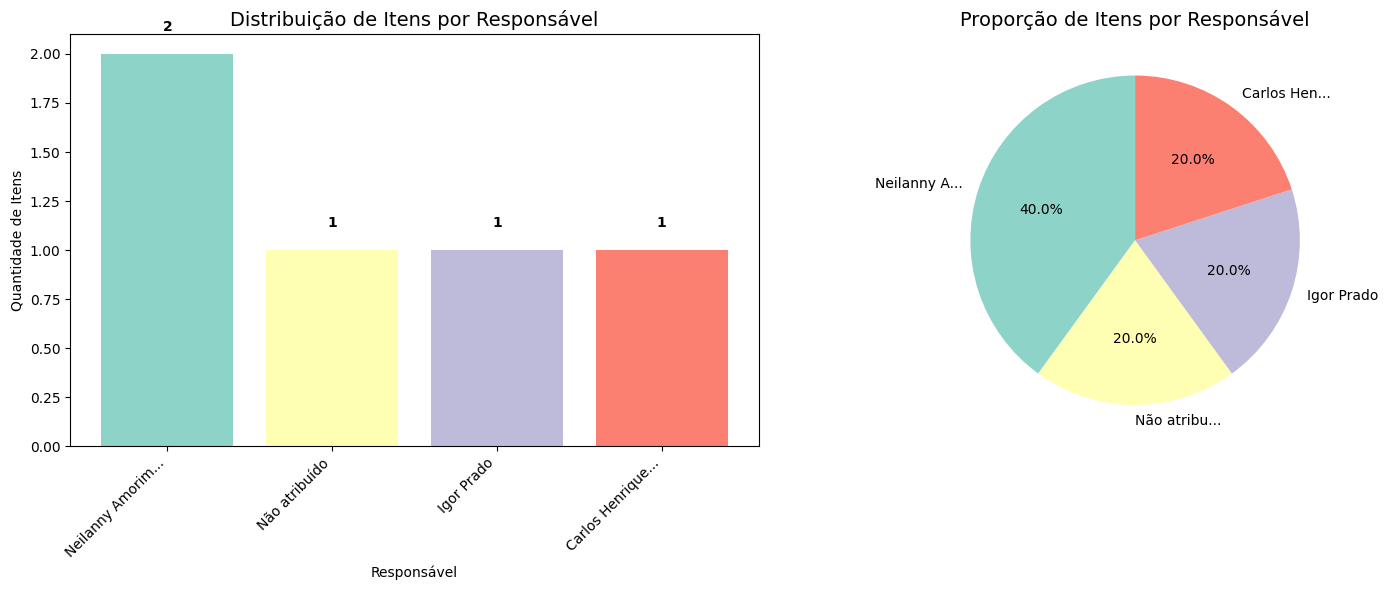


📊 ANÁLISE DE PRODUTIVIDADE POR RESPONSÁVEL:

Produtividade por responsável:
   Carlos Henrique Rodrigues Pereira:
     • Total de Story Points: 8
     • Total de Itens: 1
     • Média SP/Item: 8.0
   Igor Prado:
     • Total de Story Points: 3
     • Total de Itens: 1
     • Média SP/Item: 3.0
   Neilanny Amorim Fernandes:
     • Total de Story Points: 8
     • Total de Itens: 2
     • Média SP/Item: 4.0
   Não atribuído:
     • Total de Story Points: 3
     • Total de Itens: 1
     • Média SP/Item: 3.0


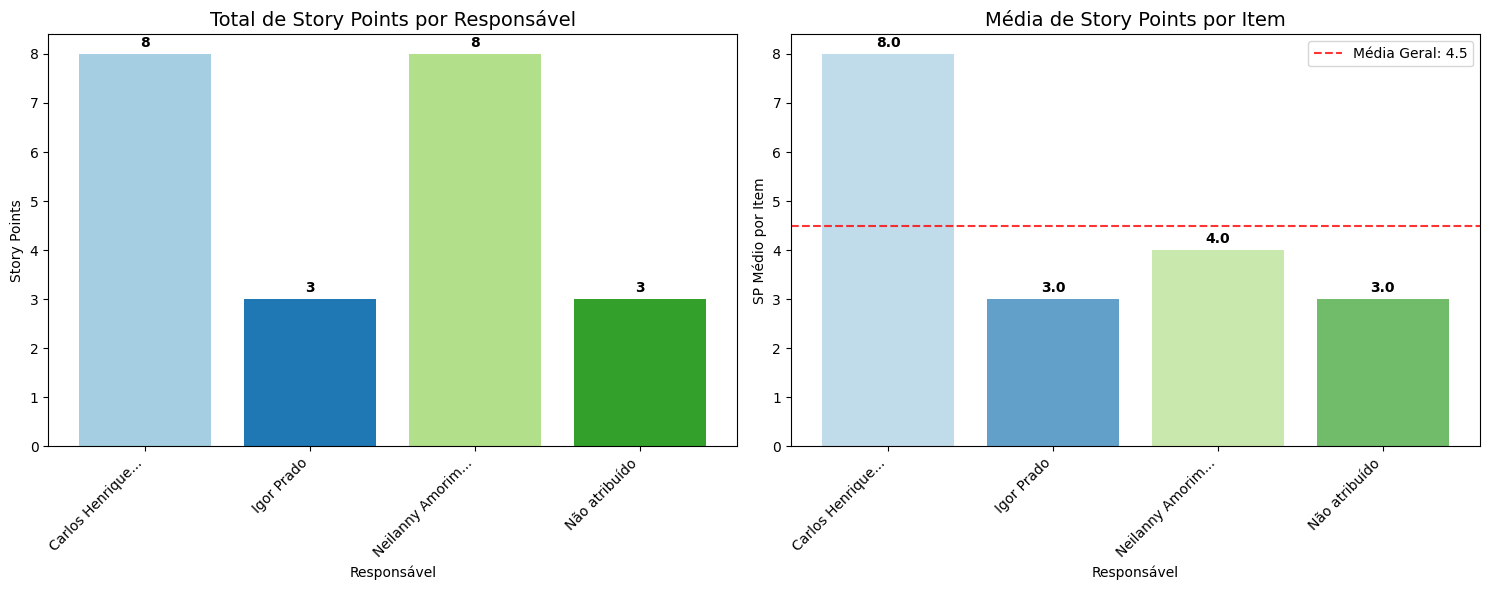


📈 ESTATÍSTICAS GERAIS DE PRODUTIVIDADE:
   Média geral de SP por item: 4.5
   Responsável mais produtivo (SP total): Carlos Henrique Rodrigues Pereira (8 SP)
   Melhor média SP/item: Carlos Henrique Rodrigues Pereira (8.0 SP/item)

💾 Para salvar os dados:
df_sprint.to_csv('smd_4450_analysis.csv', index=False)

🏁 Análise da sprint concluída!

🔧 PARA ANALISAR OUTRAS SPRINTS:
Execute novamente a célula e digite o projeto e sprint desejados.


In [ ]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import os

# Configuração do Jira
JIRA_URL = os.getenv('JIRA_URL', "https://bancomaster.atlassian.net")  
JIRA_EMAIL = os.getenv('JIRA_EMAIL', 'rjunior.nava@bancomaster.com.br')  
JIRA_TOKEN = os.getenv('JIRA_API_TOKEN', '')  # AJUSTE AQUI



def descobrir_campo_responsavel():
    """
    Descobre o campo customizado correto para responsável usando um item conhecido
    """
    # Usar o item SMD-2180 como referência que sabemos ter "Neilanny Amorim Fernandes"
    url = f"{JIRA_URL}/rest/api/3/issue/SMD-2180"
    
    try:
        response = requests.get(
            url,
            auth=HTTPBasicAuth(JIRA_EMAIL, JIRA_TOKEN),
            headers={'Accept': 'application/json'}
        )
        
        if response.status_code == 200:
            issue_data = response.json()
            fields = issue_data['fields']
            
            # Procurar "Neilanny Amorim Fernandes" em todos os campos customizados
            for field_key, field_value in fields.items():
                if field_key.startswith('customfield_') and field_value is not None:
                    nome_encontrado = None
                    
                    if isinstance(field_value, dict) and 'displayName' in field_value:
                        nome_encontrado = field_value.get('displayName', '')
                    elif isinstance(field_value, str):
                        nome_encontrado = field_value
                    
                    if nome_encontrado and 'Neilanny Amorim Fernandes' in nome_encontrado:
                        print(f"✅ Campo responsável descoberto: {field_key}")
                        return field_key
        
        print("❌ Campo responsável não encontrado no item de referência")
        return None
        
    except Exception as e:
        print(f"❌ Erro ao descobrir campo responsável: {str(e)}")
        return None

def buscar_sprint_jira(projeto, sprint_id, todos_tipos=True):
    """
    Busca dados de uma sprint específica no Jira via API
    
    Args:
        projeto: Nome do projeto no Jira
        sprint_id: ID da sprint
        todos_tipos: Se True, busca todos os tipos de issue
    
    Returns:
        dict: Dados da sprint em formato JSON
    """
    # Descobrir o campo responsável correto
    campo_responsavel = descobrir_campo_responsavel()
    if not campo_responsavel:
        campo_responsavel = 'assignee'  # fallback
    
    # Query JQL com projeto configurável
    jql = f'project = "{projeto}" AND Sprint = {sprint_id}'
    
    if not todos_tipos:
        jql += " AND issuetype in (Story, Bug, Task)"
    
    # Ordenar por Story Points (customfield_10031)
    jql += " ORDER BY cf[10031] ASC"
    
    print(f"🔍 Executando JQL: {jql}")
    
    # URL da API do Jira
    url = f"{JIRA_URL}/rest/api/3/search"
    
    # Parâmetros da requisição - incluir apenas o campo responsável descoberto
    fields_busca = f'key,summary,issuetype,status,assignee,priority,created,resolutiondate,customfield_10031'
    if campo_responsavel != 'assignee':
        fields_busca += f',{campo_responsavel}'
    
    params = {
        'jql': jql,
        'maxResults': 100,
        'fields': fields_busca
    }
    
    try:
        # Fazer requisição à API
        response = requests.get(
            url,
            params=params,
            auth=HTTPBasicAuth(JIRA_EMAIL, JIRA_TOKEN),
            headers={'Accept': 'application/json'}
        )
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ Erro ao buscar sprint {sprint_id}: Status {response.status_code}")
            print(f"   Resposta: {response.text}")
            return None
            
    except Exception as e:
        print(f"❌ Erro ao conectar com Jira: {str(e)}")
        return None

def processar_dados_sprint(data):
    """
    Processa dados da sprint
    """
    if not data or 'issues' not in data:
        return pd.DataFrame()
        
    dados = []
    
    for i, issue in enumerate(data['issues']):
        fields = issue['fields']
        
        # Calcular lead time
        lead_time = None
        if fields.get('created') and fields.get('resolutiondate'):
            try:
                created = pd.to_datetime(fields['created'])
                resolved = pd.to_datetime(fields['resolutiondate'])
                lead_time = (resolved - created).days
            except:
                pass
        
        # Tentar encontrar o campo responsável correto
        responsavel = "Não atribuído"
        
        # Campos customizados mais prováveis para responsável (baseado no CSV)
        # Expandindo a busca para encontrar o campo com nomes reais
        campos_responsavel_suspeitos = [
            'customfield_10024', 'customfield_10025', 'customfield_10026', 'customfield_10027',
            'customfield_10028', 'customfield_10029', 'customfield_10030', 'customfield_10032',
            'customfield_10033', 'customfield_10034', 'customfield_10035', 'customfield_10036',
            'customfield_10037', 'customfield_10038', 'customfield_10039', 'customfield_10040',
            'customfield_10019', 'customfield_10018', 'customfield_10021', 'customfield_10022'
        ]
        
        # Nomes esperados do CSV para validação
        nomes_esperados = [
            'Neilanny Amorim Fernandes', 'Ana Claudia da Silva', 
            'Carlos Henrique Rodrigues Pereira', 'gcoutinho.works',
            'Lorena Lima da Silveira dos Santos', 'Williana Karla da Silva',
            'Leonardo Reblin', 'Igor Prado'
        ]
        
        # Procurar o campo responsável nos campos suspeitos
        campo_encontrado = None
        for campo in campos_responsavel_suspeitos:
            if fields.get(campo):
                valor_campo = fields[campo]
                nome_encontrado = None
                
                # Verificar se é um campo de usuário
                if isinstance(valor_campo, dict) and 'displayName' in valor_campo:
                    nome_encontrado = valor_campo.get('displayName', '')
                elif isinstance(valor_campo, str) and len(valor_campo) < 100:
                    nome_encontrado = valor_campo
                
                # Verificar se o nome encontrado é um dos nomes esperados
                if nome_encontrado and any(nome in nome_encontrado for nome in nomes_esperados):
                    responsavel = nome_encontrado
                    campo_encontrado = campo
                    break
        

        
        # Fallback para assignee se nenhum campo responsável foi encontrado
        if responsavel == "Não atribuído" and fields.get('assignee'):
            responsavel = fields['assignee'].get('displayName', 'Não identificado')
        
        # Story Points apenas para tipos ágeis
        tipo_item = fields['issuetype']['name']
        if tipo_item in ['História', 'Debito Tecnico', 'Spike']:
            story_points = fields.get('customfield_10031', 0) or 0
        else:
            story_points = 0
            
        dados.append({
            'Chave': issue['key'],
            'Tipo de Item': tipo_item,
            'Status': fields['status']['name'],
            'Resumo': fields.get('summary', '')[:60] + '...' if len(fields.get('summary', '')) > 60 else fields.get('summary', ''),
            'Responsável': responsavel,
            'Prioridade': fields.get('priority', {}).get('name', 'N/A') if fields.get('priority') else 'N/A',
            'Criado': fields.get('created', '')[:10],
            'Resolvido': fields.get('resolutiondate', '')[:10] if fields.get('resolutiondate') else '',
            'Lead Time (dias)': lead_time,
            'Story Points': story_points
        })
    return pd.DataFrame(dados)

# Funções para métricas ágeis
def mostrar_distribuicao_por_tipo(df):
    """Mostra distribuição por tipo de item focando nos tipos ágeis"""
    print("\n📊 DISTRIBUIÇÃO POR TIPO DE ITEM:")
    
    # Filtrar apenas tipos ágeis de interesse
    tipos_ageis = ['Debito Tecnico', 'História', 'Spike']
    df_filtrado = df[df['Tipo de Item'].isin(tipos_ageis)]
    
    if len(df_filtrado) == 0:
        print("   Nenhum item dos tipos ágeis (Débito Técnico, História, Spike) encontrado")
        return
    
    tipo_counts = df_filtrado['Tipo de Item'].value_counts()
    for tipo, count in tipo_counts.items():
        print(f"   {tipo}: {count}")
    
    # Gráfico com quantidade nas barras
    plt.figure(figsize=(8,5))
    bars = tipo_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('Distribuição por Tipo de Item (Framework Ágil)', fontsize=14)
    plt.ylabel('Quantidade de Itens')
    plt.xlabel('Tipo de Item')
    plt.xticks(rotation=45)
    
    # Adicionar quantidade nas barras
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def mostrar_items_concluidos_ageis(df):
    """Mostra apenas itens ágeis concluídos"""
    tipos_ageis = ['História', 'Debito Tecnico', 'Spike']
    status_concluidos = ['Concluído', 'Done', 'Fechado', 'Finalizado', 'Resolvido']
    
    df_ageis = df[df['Tipo de Item'].isin(tipos_ageis)]
    df_concluidos = df_ageis[df_ageis['Status'].isin(status_concluidos)]
    
    print(f"\n✅ ITENS ÁGEIS CONCLUÍDOS NA SPRINT: {len(df_concluidos)}")
    
    if len(df_concluidos) > 0:
        print("\nItens concluídos (História, Débito Técnico, Spike):")
        colunas_exibir = ['Chave', 'Tipo de Item', 'Status', 'Resumo', 'Responsável']
        print(df_concluidos[colunas_exibir].to_string(index=False, justify='left'))
    
    return df_concluidos



def mostrar_story_points_ageis(df, df_concluidos):
    """Mostra Story Points apenas para tipos ágeis"""
    tipos_ageis = ['História', 'Debito Tecnico', 'Spike']
    
    # Filtrar apenas tipos ágeis
    df_ageis = df[df['Tipo de Item'].isin(tipos_ageis)]
    df_concluidos_ageis = df_concluidos[df_concluidos['Tipo de Item'].isin(tipos_ageis)]
    
    total_sp = df_ageis['Story Points'].sum()
    sp_concluidos = df_concluidos_ageis['Story Points'].sum()
    
    print(f"\n🎯 STORY POINTS (APENAS ITENS ÁGEIS):")
    print(f"   Total planejado: {total_sp}")
    print(f"   Total concluído: {sp_concluidos}")
    print(f"   % Concluído: {(sp_concluidos/total_sp*100):.1f}%" if total_sp > 0 else "   N/A")
    
    # Mostrar detalhamento apenas de itens com Story Points
    df_com_sp = df_ageis[df_ageis['Story Points'] > 0]
    if len(df_com_sp) > 0:
        print(f"\n📊 DETALHAMENTO DOS STORY POINTS:")
        print(df_com_sp[['Chave', 'Tipo de Item', 'Status', 'Story Points']].to_string(index=False))
        
        # Story Points por tipo
        print(f"\n📈 STORY POINTS POR TIPO:")
        sp_por_tipo = df_com_sp.groupby('Tipo de Item')['Story Points'].sum().sort_values(ascending=False)
        for tipo, sp in sp_por_tipo.items():
            print(f"   {tipo}: {sp} pontos")
    else:
        print("\n⚠️  Nenhum Story Point encontrado nos itens ágeis!")
        print("   Verifique se o campo customfield_10031 está correto para sua instância do Jira")
    
    # Gráfico de Story Points
    plt.figure(figsize=(10, 5))
    
    # Subplot 1: Planejado vs Concluído
    plt.subplot(1, 2, 1)
    plt.bar(['Planejado', 'Concluído'], [total_sp, sp_concluidos], 
            color=['#74B9FF', '#00B894'])
    plt.title('Story Points: Planejado vs Concluído')
    plt.ylabel('Story Points')
    
    # Adicionar valores nas barras
    for i, v in enumerate([total_sp, sp_concluidos]):
        plt.text(i, v + max(total_sp, sp_concluidos) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')
    
    # Subplot 2: Por tipo (se houver dados)
    if len(df_com_sp) > 0:
        plt.subplot(1, 2, 2)
        sp_por_tipo = df_com_sp.groupby('Tipo de Item')['Story Points'].sum()
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        bars = plt.bar(sp_por_tipo.index, sp_por_tipo.values, color=colors[:len(sp_por_tipo)])
        plt.title('Story Points por Tipo de Item')
        plt.ylabel('Story Points')
        plt.xticks(rotation=45)
        
        # Adicionar valores nas barras
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height * 0.01,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def mostrar_distribuicao_responsaveis(df):
    """Mostra distribuição de itens por responsável com visualizações gráficas"""
    tipos_ageis = ['História', 'Debito Tecnico', 'Spike']
    df_ageis = df[df['Tipo de Item'].isin(tipos_ageis)]
    
    print(f"\n👥 DISTRIBUIÇÃO DE ITENS POR RESPONSÁVEL (ITENS ÁGEIS):")
    responsavel_counts = df_ageis['Responsável'].value_counts()
    
    # Exibir contagem textual
    for responsavel, count in responsavel_counts.items():
        print(f"   {responsavel}: {count} itens")
    
    # Gráficos de distribuição
    if len(responsavel_counts) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Gráfico de barras
        colors = plt.cm.Set3(range(len(responsavel_counts)))
        bars = ax1.bar(range(len(responsavel_counts)), responsavel_counts.values, color=colors)
        ax1.set_title('Distribuição de Itens por Responsável', fontsize=14)
        ax1.set_ylabel('Quantidade de Itens')
        ax1.set_xlabel('Responsável')
        ax1.set_xticks(range(len(responsavel_counts)))
        ax1.set_xticklabels([nome[:15] + '...' if len(nome) > 15 else nome 
                            for nome in responsavel_counts.index], rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, count in zip(bars, responsavel_counts.values):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                    str(count), ha='center', va='bottom', fontweight='bold')
        
        # Gráfico de pizza
        ax2.pie(responsavel_counts.values, labels=[nome[:10] + '...' if len(nome) > 10 else nome 
                                                  for nome in responsavel_counts.index], 
                autopct='%1.1f%%', startangle=90, colors=colors)
        ax2.set_title('Proporção de Itens por Responsável', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        # Calcular e exibir média de produtividade
        mostrar_media_produtividade(df_ageis)
    else:
        print("   ⚠️  Nenhum item ágil encontrado para análise de responsáveis")

def mostrar_media_produtividade(df_ageis):
    """Calcula e exibe média de produtividade por responsável"""
    print(f"\n📊 ANÁLISE DE PRODUTIVIDADE POR RESPONSÁVEL:")
    
    # Calcular story points por responsável
    produtividade = df_ageis.groupby('Responsável').agg({
        'Story Points': 'sum',
        'Chave': 'count'
    }).rename(columns={'Chave': 'Total_Itens'})
    
    # Calcular média de story points por item
    produtividade['Media_SP_por_Item'] = produtividade['Story Points'] / produtividade['Total_Itens']
    produtividade = produtividade.fillna(0)
    
    # Filtrar apenas responsáveis com story points
    produtividade_valida = produtividade[produtividade['Story Points'] > 0]
    
    if len(produtividade_valida) > 0:
        print("\nProdutividade por responsável:")
        for responsavel, dados in produtividade_valida.iterrows():
            print(f"   {responsavel}:")
            print(f"     • Total de Story Points: {dados['Story Points']:.0f}")
            print(f"     • Total de Itens: {dados['Total_Itens']:.0f}")
            print(f"     • Média SP/Item: {dados['Media_SP_por_Item']:.1f}")
        
        # Gráfico de produtividade
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Gráfico 1: Story Points por responsável
        responsaveis = produtividade_valida.index
        story_points = produtividade_valida['Story Points']
        colors = plt.cm.Paired(range(len(responsaveis)))
        
        bars1 = ax1.bar(range(len(responsaveis)), story_points, color=colors)
        ax1.set_title('Total de Story Points por Responsável', fontsize=14)
        ax1.set_ylabel('Story Points')
        ax1.set_xlabel('Responsável')
        ax1.set_xticks(range(len(responsaveis)))
        ax1.set_xticklabels([nome[:15] + '...' if len(nome) > 15 else nome 
                            for nome in responsaveis], rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, sp in zip(bars1, story_points):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(story_points) * 0.01,
                    f'{sp:.0f}', ha='center', va='bottom', fontweight='bold')
        
        # Gráfico 2: Média de SP por item
        media_sp = produtividade_valida['Media_SP_por_Item']
        bars2 = ax2.bar(range(len(responsaveis)), media_sp, color=colors, alpha=0.7)
        ax2.set_title('Média de Story Points por Item', fontsize=14)
        ax2.set_ylabel('SP Médio por Item')
        ax2.set_xlabel('Responsável')
        ax2.set_xticks(range(len(responsaveis)))
        ax2.set_xticklabels([nome[:15] + '...' if len(nome) > 15 else nome 
                            for nome in responsaveis], rotation=45, ha='right')
        
        # Adicionar valores nas barras
        for bar, media in zip(bars2, media_sp):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(media_sp) * 0.01,
                    f'{media:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # Linha de média geral
        media_geral = media_sp.mean()
        ax2.axhline(y=media_geral, color='red', linestyle='--', alpha=0.8, 
                   label=f'Média Geral: {media_geral:.1f}')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas gerais
        print(f"\n📈 ESTATÍSTICAS GERAIS DE PRODUTIVIDADE:")
        print(f"   Média geral de SP por item: {media_geral:.1f}")
        print(f"   Responsável mais produtivo (SP total): {story_points.idxmax()} ({story_points.max():.0f} SP)")
        print(f"   Melhor média SP/item: {media_sp.idxmax()} ({media_sp.max():.1f} SP/item)")
        
    else:
        print("   ⚠️  Nenhum responsável com story points encontrado para análise de produtividade")

def listar_issue_types(df):
    """Lista todos os tipos de issue da Sprint atual"""
    print(f"\n📋 TODOS OS TIPOS DE ISSUE DA SPRINT:")
    issue_types = df['Tipo de Item'].value_counts()
    total_issues = len(df)
    
    for issue_type, count in issue_types.items():
        percentage = (count / total_issues * 100)
        print(f"   {issue_type}: {count} itens ({percentage:.1f}%)")
    
    print(f"\n   Total de itens na sprint: {total_issues}")

def salvar_dados(df, projeto, sprint_id):
    filename = f"{projeto.replace(' ', '_').replace('[', '').replace(']', '')}_{sprint_id}_analysis.csv"
    print(f"\n💾 Para salvar os dados:")
    print(f"df_sprint.to_csv('{filename}', index=False)")

def analisar_sprint(projeto, sprint_id):
    print(f"🚀 ANÁLISE DA SPRINT {sprint_id} - PROJETO {projeto}")
    print("="*70)
    
    data_sprint = buscar_sprint_jira(projeto, sprint_id, todos_tipos=True)
    if data_sprint:
        total_issues = data_sprint['total']
        print(f"✅ Total de issues na sprint: {total_issues}")
        if total_issues > 0:
            df_sprint = processar_dados_sprint(data_sprint)
            pd.set_option('display.colheader_justify', 'left')
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', 50)
            
            # Análises focadas em framework ágil
            listar_issue_types(df_sprint)
            mostrar_distribuicao_por_tipo(df_sprint)
            df_concluidos = mostrar_items_concluidos_ageis(df_sprint)
            mostrar_story_points_ageis(df_sprint, df_concluidos)
            mostrar_distribuicao_responsaveis(df_sprint)
            salvar_dados(df_sprint, projeto, sprint_id)
        else:
            print("❌ Nenhum issue encontrado na sprint")
    else:
        print("❌ Erro ao buscar dados da sprint")
    print(f"\n🏁 Análise da sprint concluída!")
    print("="*70)

# Entrada dinâmica para análise de sprint
print("🔧 CONFIGURAÇÃO DA ANÁLISE")
print("="*40)

try:
    projeto_input = input('Digite o nome do projeto (ex: [DIGITAL] CredCesta CORE): ').strip()
    if not projeto_input:
        projeto_input = "[DIGITAL] CredCesta CORE"  # Valor padrão
        print(f"Usando projeto padrão: {projeto_input}")
except Exception:
    projeto_input = "[DIGITAL] CredCesta CORE"

try:
    sprint_id_input = int(input('Digite o número da Sprint para análise: '))
except Exception:
    sprint_id_input = 2614  # Valor padrão caso não seja informado corretamente
    print(f"Usando sprint padrão: {sprint_id_input}")

analisar_sprint(projeto_input, sprint_id_input)

print(f"\n🔧 PARA ANALISAR OUTRAS SPRINTS:")
print("="*50)
print("Execute novamente a célula e digite o projeto e sprint desejados.")